# 2-Data Wrangling Script
Date created: 16/04/23  
Created by: Jayden Dzierbicki  
Last updated: 16/04/23  

The purpose of this notebook is to undertake the following in prepration for machine learning
- Data wrangling and cleaning
- NLP techniques 
- EDA
- Clean data saved and stored into mySQL/csv


In [1]:
import getpass
from sqlalchemy import create_engine # For connecting to SQL databases
import pandas as pd

# Function to load data into mySQL
def extract_data_mySQL(database_name, table_name):
    user = 'root'

    # Prompt the user for a password
    password = getpass.getpass("Enter your MySQL password: ")
    host = 'localhost'
    port = 3306
    database = database_name
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

    # Write the DataFrame to a SQL table
    table_name =  table_name
    query = f"SELECT * FROM {table_name}"
    
    # Read query to dataframe
    df = pd.read_sql(query, engine)
    return(df)

    # Close the connection
    engine.dispose()

## Data wrangling and cleaning
- Load in data
- Quick EDA of loaded data
- Decsions based on EDA - period of analysis
- Test and remove duplicates i.e. user could spam a forum board 
- NLP

Decsions made in this section include:
- Analysis from 2021-02-02 -> 2023-04-14: Limitations of data retrival for cryptocompare.com

In [2]:
# Load in data sources
cryptocompare_xrp = extract_data_mySQL('MA5851_A3', 'cryptocompare_xrp')
investingcom_xrp = extract_data_mySQL('MA5851_A3', 'investingcom_xrp')
xrp_price_yahoo = extract_data_mySQL('MA5851_A3', 'xrp_price_yahoo')

Enter your MySQL password: ········
Enter your MySQL password: ········
Enter your MySQL password: ········


In [3]:
def get_min_max_dates(table, table_name):
    print(f'Min and max date range of {table_name}')
    print(f'MIN Date: {table.date.min()}')
    print(f'MAX Date: {table.date.max()}')
    print("-----------------------------")


get_min_max_dates(cryptocompare_xrp, "cryptocompare_xrp")
get_min_max_dates(investingcom_xrp, "investingcom_xrp")
get_min_max_dates(xrp_price_yahoo, "xrp_price_yahoo")


Min and max date range of cryptocompare_xrp
MIN Date: 2021-02-02
MAX Date: 2023-04-14
-----------------------------
Min and max date range of investingcom_xrp
MIN Date: 2018-03-16
MAX Date: 2023-04-14
-----------------------------
Min and max date range of xrp_price_yahoo
MIN Date: 2017-11-10 00:00:00
MAX Date: 2023-04-14 00:00:00
-----------------------------


In [4]:
# Filter all data by date range, using data from 2021-02-02 onwards
min_date_filter = pd.to_datetime('2021-02-02')  # Used to filter min date

def filter_by_min_date(date_filter, df, table_name):
    df['date'] = pd.to_datetime(df['date'])
    filtered_df = df[df['date'] >= date_filter]
    rows_removed = len(df) - len(filtered_df)
    print(f"Number of rows filtered by date from {table_name}: {rows_removed}")
    print("---------------------------------------------------------")
    return filtered_df

filtered_investingcom_xrp = filter_by_min_date(min_date_filter, investingcom_xrp, "investingcom_xrp")
filtered_xrp_price_yahoo = filter_by_min_date(min_date_filter, xrp_price_yahoo, "xrp_price_yahoo")
filtered_cryptocompare_xrp = filter_by_min_date(min_date_filter, cryptocompare_xrp, "cryptocompare_xrp")


Number of rows filtered by date from investingcom_xrp: 26268
---------------------------------------------------------
Number of rows filtered by date from xrp_price_yahoo: 1180
---------------------------------------------------------
Number of rows filtered by date from cryptocompare_xrp: 0
---------------------------------------------------------


In [5]:
# Remove NA observations from comments
def remove_na_values(df, table_name, variable):
    output = df.dropna(subset=[variable])
    rows_removed = len(df) - len(output)
    print(f"Number of NA rows removed from {table_name}: {rows_removed}")
    print("---------------------------------------------------------")
    return output

# Assuming cryptocompare_xrp is a pandas DataFrame with a 'comment' column
cleaned_cryptocompare_xrp = remove_na_values(filtered_investingcom_xrp, "cryptocompare_xrp", "comment")
cleaned_investingcom_xrp = remove_na_values(filtered_cryptocompare_xrp, "investingcom_xrp", "comment")


Number of NA rows removed from cryptocompare_xrp: 43
---------------------------------------------------------
Number of NA rows removed from investingcom_xrp: 129
---------------------------------------------------------


In [6]:
def preview_duplicate_comments(df, table_name):
    # Find duplicates based on 'date' and 'comment' columns
    duplicates = df[df.duplicated(subset=['date', 'comment'], keep=False)]

    # Group the duplicates by 'date' and 'comment' columns and count their occurrences
    duplicate_counts = duplicates.groupby(['date', 'comment']).size().reset_index(name='count')

    # Sort the DataFrame by the 'count' column in descending order
    duplicate_counts_sorted = duplicate_counts.sort_values(by='count', ascending=False)

    # Print the count for each specific duplicate
    print(f"Duplicate preview for {table_name}")
    print(duplicate_counts_sorted)
    print("-------------------------------------------------------------------------")

def remove_duplicate_comments(df, table_name):
    # Remove duplicates
    unique_df = df.drop_duplicates(subset=['date', 'comment'])
    duplicates_removed = len(df) - len(unique_df)
    print(f'Number of duplicates removed from {table_name}: {duplicates_removed}')
    print("-------------------------------------------------------------------------")
    return unique_df

# Preview and remove duplicates
preview_duplicate_comments(cleaned_cryptocompare_xrp, "cleaned_cryptocompare_xrp")
preview_duplicate_comments(cleaned_investingcom_xrp, "cleaned_investingcom_xrp")

cleaned_cryptocompare_xrp_2 = remove_duplicate_comments(cleaned_cryptocompare_xrp, "cleaned_cryptocompare_xrp")
cleaned_investingcom_xrp_2 = remove_duplicate_comments(cleaned_investingcom_xrp, "cleaned_investingcom_xrp")

Duplicate preview for cleaned_cryptocompare_xrp
          date                                            comment  count
124 2021-04-13                                                lol      6
96  2021-04-10                                                lol      5
38  2021-02-21                                            shut up      4
105 2021-04-11  My newbie opinion: if price break 1.3200, it m...      4
25  2021-02-14  Guys, how long do u suppose this place of resi...      4
..         ...                                                ...    ...
118 2021-04-13  Im not selling a penny till we beat the SEC an...      2
117 2021-04-13                                   Here we go again      2
116 2021-04-13                                              HODL🚀      2
115 2021-04-13                                              Bitso      2
337 2022-11-18  Exactly! Even 10% of swift business puts this ...      2

[338 rows x 3 columns]
----------------------------------------------------

In [7]:
# Join text data together retaining date, source and comment
text_data = pd.concat([cleaned_investingcom_xrp_2, cleaned_cryptocompare_xrp_2])[['date', 'source', 'comment']]

# create a new dataframe with the count of comments by date and source
count_data = text_data.groupby(['date', 'source']).size().reset_index(name='count')

# calculate the average number of posts per day - all sources
avg_posts_per_day = count_data.groupby('date')['count'].mean().mean()
print('Average number of posts per day: {:.2f}'.format(avg_posts_per_day))

# calculate the median number of posts per day - all sources
med_posts_per_day = count_data.groupby('date')['count'].median().median()
print('Median number of posts per day: {:.2f}'.format(med_posts_per_day))

Average number of posts per day: 24.84
Median number of posts per day: 8.50


In [9]:
# Qucik EDA to undertsand distrubtion of 
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive
import numpy as np


# define a function that plots the count of comments for a given date range
def plot_comments(start_date, end_date):
    start_date = np.datetime64(start_date)
    end_date = np.datetime64(end_date)
    data = count_data[(count_data['date'] >= start_date) & (count_data['date'] <= end_date)]
    fig, ax = plt.subplots(figsize=(12, 6))
    for source in data['source'].unique():
        source_data = data[data['source'] == source]
        ax.plot(source_data['date'], source_data['count'], label=source)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of comments')
    ax.set_title('Number of comments by source and date')
    ax.legend()
    plt.show()


# create a date slider widget
start_date_widget = widgets.DatePicker(description='Start date:', value=min(count_data['date']))
end_date_widget = widgets.DatePicker(description='End date:', value=max(count_data['date']))

# create an interactive plot using the date slider widget
interactive_plot = interactive(plot_comments, start_date=start_date_widget, end_date=end_date_widget)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot


interactive(children=(DatePicker(value=Timestamp('2021-02-02 00:00:00'), description='Start date:'), DatePicke…

### Graph Intepreation & Next steps:
During the period between March and April of 2020-2021, there were significant developments in the legal battle between SEC and Ripple, which is reflected in the online forum discussions. This increase in discussions was particularly noticeable on the Cryptocompare platform, with a substantial spike during that period. For more information on the SEC vs. Ripple lawsuit, refer to this article: https://cointelegraph.com/learn/the-sec-vs-ripple-lawsuit-everything-you-need-to-know.

#### At this stage we have commpleted the following tasks:
- Filtered all data 
- Remove missing observations
- Remove duplicates
- Joined text data together & quick EDA of sample distrubtion

#### The next stages will invlove:
- Text cleanining (unwanted characters, HTML elements, conver to lower case etc)
- Tokenization (Tokenize the text data into indivdual workds or tokens)
- Stopword removal (debating as this can loose meaning of word)
- Lemmatization or stemming (debating)
- Embedding matrix?

In [11]:
import re
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))



def clean_text(text):
    # Remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # Remove everything except alphabets 
    #text = re.sub("[^a-zA-Z]"," ",text) 
    # Remove whitespaces 
    text = ' '.join(text.split()) 
    # Convert text to lowercase 
    text = text.lower() 
    text = word_tokenize(text)
    return text



def clean_text(text):
    # Remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # Remove everything except alphabets 
    #text = re.sub("[^a-zA-Z]"," ",text) 
    # Remove whitespaces 
    text = ' '.join(text.split()) 
    # Convert text to lowercase 
    text = text.lower() 
    text = ' '.join(word_tokenize(text))
    return text

def remove_stopwords_and_stem(text):
#    # Remove stop words and stem words
    stemmer = PorterStemmer()
    tokens = word_tokenize(text.lower())
#    no_stopword_text = [stemmer.stem(w) for w in tokens if not w in stop_words]
    return ' '.join(no_stopword_text)


#def clean_text(text ): 
 #   delete_dict = {sp_character: ' ' for sp_character in string.punctuation} 
 #   delete_dict[' '] = ' ' 
 #   table = str.maketrans(delete_dict)
 #   text1 = text.translate(table)
 #   #print('cleaned:'+text1)
 #   textArr= text1.split()
 #   text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
 #   return text2.lower().split(' ')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# Clean all the comments in the 'comment' column of the DataFrame
text_data['cleaned_comment'] = text_data['comment'].apply(clean_text)
#text_data['cleaned_comment'] = text_data['cleaned_comment'].apply(remove_stopwords_and_stem)
text_data

date                                         source  \
0     2023-04-14  https://www.cryptocompare.com/coins/xrp/forum   
1     2023-04-14  https://www.cryptocompare.com/coins/xrp/forum   
2     2023-04-14  https://www.cryptocompare.com/coins/xrp/forum   
3     2023-04-13  https://www.cryptocompare.com/coins/xrp/forum   
4     2023-04-13  https://www.cryptocompare.com/coins/xrp/forum   
...          ...                                            ...   
33475 2021-02-02      https://www.investing.com/crypto/xrp/chat   
33476 2021-02-02      https://www.investing.com/crypto/xrp/chat   
33477 2021-02-02      https://www.investing.com/crypto/xrp/chat   
33478 2021-02-02      https://www.investing.com/crypto/xrp/chat   
33479 2021-02-02      https://www.investing.com/crypto/xrp/chat   

                                                 comment  \
0      moon soon, coon. mark my words (lol idk - no f...   
1                               Boring xrp at the Moment   
2      So bankrupted FTX….they recover $7.3 billion i...   
3      Is UMU what many thought XRP was going to be u...   
4      Coinbase just deposited Flare into my account....   
...                                                  ...   
33475                                        XRP=PORTELO   
33476                    new smart move is xlm stellar!✌   
33477                           xlm is not scammy enough   
33478                                              buyyy   
33479  Start Crypto Currency trading. Click below lin...   

                                         cleaned_comment  
0      moon soon , coon . mark my words ( lol idk - n...  
1                               boring xrp at the moment  
2      so bankrupted ftx….they recover $ 7.3 billion ...  
3      is umu what many thought xrp was going to be u...  
4      coinbase just deposited flare into my account ...  
...                                                  ...  
33475                                        xrp=portelo  
33476                  new smart move is xlm stellar ! ✌  
33477                           xlm is not scammy enough  
33478                                              buyyy  
33479  start crypto currency trading . click below li...  

[39319 rows x 4 columns]

In [260]:
import pandas as pd
import emoji
import pandas as pd
import emoji


# Define a function to check if a string contains emojis
def has_emoji(text):
    for character in text:
        if emoji.emoji_count(character) > 0:
            return True
    return False

# Create a new DataFrame containing only the rows with emojis
emoji_df = text_data[text_data["comment"].apply(has_emoji)]
emoji_df


date                                         source  \
2     2023-04-14  https://www.cryptocompare.com/coins/xrp/forum   
7     2023-04-11  https://www.cryptocompare.com/coins/xrp/forum   
13    2023-04-10  https://www.cryptocompare.com/coins/xrp/forum   
14    2023-04-09  https://www.cryptocompare.com/coins/xrp/forum   
26    2023-04-04  https://www.cryptocompare.com/coins/xrp/forum   
...          ...                                            ...   
33395 2021-02-02      https://www.investing.com/crypto/xrp/chat   
33402 2021-02-02      https://www.investing.com/crypto/xrp/chat   
33428 2021-02-02      https://www.investing.com/crypto/xrp/chat   
33443 2021-02-02      https://www.investing.com/crypto/xrp/chat   
33476 2021-02-02      https://www.investing.com/crypto/xrp/chat   

                                                 comment  \
2      So bankrupted FTX….they recover $7.3 billion i...   
7                          This might be interesting 🤔🤔😎   
13     What do you think will happen next?Thumbs up =...   
14     For those that are still here😂🤣🤷‍♂️ (I’m not g...   
26                           So how far is to the moon 🙃   
...                                                  ...   
33395  i just can’t wait for the day when it finally ...   
33402  Lol The hopeless is talking. Everyone listen h...   
33428  Free Dogecoin mining sign up on this site star...   
33443                                               ok 🤡   
33476                    new smart move is xlm stellar!✌   

                                         cleaned_comment  
2      [so, bankrupted, ftx….they, recover, $, 7.3, b...  
7                    [this, might, be, interesting, 🤔🤔😎]  
13     [what, do, you, think, will, happen, next, ?, ...  
14     [for, those, that, are, still, here😂🤣🤷‍♂️, (, ...  
26                  [so, how, far, is, to, the, moon, 🙃]  
...                                                  ...  
33395  [i, just, can, ’, t, wait, for, the, day, when...  
33402  [lol, the, hopeless, is, talking, ., everyone,...  
33428  [free, dogecoin, mining, sign, up, on, this, s...  
33443                                            [ok, 🤡]  
33476         [new, smart, move, is, xlm, stellar, !, ✌]  

[2886 rows x 4 columns]

In [293]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Loop through each row of the DataFrame and calculate the sentiment score for each comment
for index, row in text_data.iterrows():
    comment = row['cleaned_comment']
    scores = sia.polarity_scores(comment)
    print(f"cleaned_comment {index+1}:", scores)
text_data['sentiment_score'] = text_data['cleaned_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])


cleaned_comment 1: {'neg': 0.125, 'neu': 0.625, 'pos': 0.25, 'compound': 0.34}
cleaned_comment 2: {'neg': 0.5, 'neu': 0.5, 'pos': 0.0, 'compound': -0.25}
cleaned_comment 3: {'neg': 0.275, 'neu': 0.534, 'pos': 0.191, 'compound': -0.2732}
cleaned_comment 4: {'neg': 0.05, 'neu': 0.705, 'pos': 0.245, 'compound': 0.9042}
cleaned_comment 5: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7: {'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'compound': 0.4939}
cleaned_comment 8: {'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compound': 0.4588}
cleaned_comment 9: {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.3612}
cleaned_comment 10: {'neg': 0.067, 'neu': 0.821, 'pos': 0.111, 'compound': 0.3612}
cleaned_comment 11: {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.2732}
cleaned_comment 12: {'neg': 0.061, 'neu': 0.939, 'pos': 0.0, 'compound': -0.0772}
cleaned_comment 13: {'neg': 0.0, 'neu': 1.0, 'pos': 0.

cleaned_comment 514: {'neg': 0.254, 'neu': 0.61, 'pos': 0.136, 'compound': -0.3612}
cleaned_comment 515: {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.6908}
cleaned_comment 516: {'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.4215}
cleaned_comment 517: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 518: {'neg': 0.0, 'neu': 0.718, 'pos': 0.282, 'compound': 0.6249}
cleaned_comment 519: {'neg': 0.208, 'neu': 0.528, 'pos': 0.264, 'compound': 0.128}
cleaned_comment 520: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 521: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 522: {'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.4767}
cleaned_comment 523: {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound': 0.3612}
cleaned_comment 524: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 525: {'neg': 0.0, 'neu': 0.761, 'pos': 0.239, 'compound': 0.5719}
cleaned_comment 526: {'neg': 0.792, 'neu': 0

cleaned_comment 938: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 939: {'neg': 0.464, 'neu': 0.536, 'pos': 0.0, 'compound': -0.3818}
cleaned_comment 940: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 941: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 942: {'neg': 0.184, 'neu': 0.661, 'pos': 0.155, 'compound': -0.25}
cleaned_comment 943: {'neg': 0.079, 'neu': 0.714, 'pos': 0.207, 'compound': 0.5574}
cleaned_comment 944: {'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'compound': -0.5423}
cleaned_comment 945: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 946: {'neg': 0.194, 'neu': 0.806, 'pos': 0.0, 'compound': -0.34}
cleaned_comment 947: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 948: {'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'compound': 0.1326}
cleaned_comment 949: {'neg': 0.267, 'neu': 0.733, 'pos': 0.0, 'compound': -0.5207}
cleaned_comment 950: {'neg': 0.821, 'neu': 0.1

cleaned_comment 1423: {'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'compound': 0.296}
cleaned_comment 1424: {'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'compound': 0.296}
cleaned_comment 1425: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 1426: {'neg': 0.064, 'neu': 0.749, 'pos': 0.187, 'compound': 0.5106}
cleaned_comment 1427: {'neg': 0.0, 'neu': 0.927, 'pos': 0.073, 'compound': 0.2263}
cleaned_comment 1428: {'neg': 0.0, 'neu': 0.941, 'pos': 0.059, 'compound': 0.25}
cleaned_comment 1429: {'neg': 0.0, 'neu': 0.622, 'pos': 0.378, 'compound': 0.7845}
cleaned_comment 1430: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 1431: {'neg': 0.066, 'neu': 0.704, 'pos': 0.23, 'compound': 0.5423}
cleaned_comment 1432: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 1433: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 1434: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 1435: {'neg': 0.0, 'neu'

cleaned_comment 1858: {'neg': 0.15, 'neu': 0.586, 'pos': 0.264, 'compound': 0.5434}
cleaned_comment 1859: {'neg': 0.419, 'neu': 0.581, 'pos': 0.0, 'compound': -0.5574}
cleaned_comment 1860: {'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'compound': -0.1531}
cleaned_comment 1861: {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.5106}
cleaned_comment 1862: {'neg': 0.0, 'neu': 0.185, 'pos': 0.815, 'compound': 0.9217}
cleaned_comment 1863: {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.5106}
cleaned_comment 1864: {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.5106}
cleaned_comment 1865: {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.5106}
cleaned_comment 1866: {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.5106}
cleaned_comment 1867: {'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'compound': 0.7717}
cleaned_comment 1868: {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.5106}
cleaned_comment 1869: {'neg': 0.0, 'neu': 0.377, 'pos': 0.623, 'compound': 0.765}
cl

cleaned_comment 2301: {'neg': 0.294, 'neu': 0.706, 'pos': 0.0, 'compound': -0.3612}
cleaned_comment 2302: {'neg': 0.089, 'neu': 0.635, 'pos': 0.277, 'compound': 0.5325}
cleaned_comment 2303: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2304: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2305: {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.34}
cleaned_comment 2306: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2307: {'neg': 0.105, 'neu': 0.82, 'pos': 0.074, 'compound': -0.2023}
cleaned_comment 2308: {'neg': 0.0, 'neu': 0.702, 'pos': 0.298, 'compound': 0.5267}
cleaned_comment 2309: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2310: {'neg': 0.321, 'neu': 0.374, 'pos': 0.305, 'compound': -0.128}
cleaned_comment 2311: {'neg': 0.155, 'neu': 0.704, 'pos': 0.141, 'compound': -0.0571}
cleaned_comment 2312: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2313: {'neg': 0

cleaned_comment 2729: {'neg': 0.5, 'neu': 0.5, 'pos': 0.0, 'compound': -0.25}
cleaned_comment 2730: {'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'compound': 0.4449}
cleaned_comment 2731: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2732: {'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.3182}
cleaned_comment 2733: {'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.9287}
cleaned_comment 2734: {'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.802}
cleaned_comment 2735: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2736: {'neg': 0.1, 'neu': 0.7, 'pos': 0.2, 'compound': 0.7449}
cleaned_comment 2737: {'neg': 0.14, 'neu': 0.86, 'pos': 0.0, 'compound': -0.2755}
cleaned_comment 2738: {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.3182}
cleaned_comment 2739: {'neg': 0.02, 'neu': 0.632, 'pos': 0.348, 'compound': 0.9732}
cleaned_comment 2740: {'neg': 0.218, 'neu': 0.558, 'pos': 0.224, 'compound': -0.7579}
cleaned_comment 2741: {'n

cleaned_comment 3120: {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.4019}
cleaned_comment 3121: {'neg': 0.0, 'neu': 0.632, 'pos': 0.368, 'compound': 0.7906}
cleaned_comment 3122: {'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}
cleaned_comment 3123: {'neg': 0.075, 'neu': 0.753, 'pos': 0.172, 'compound': 0.5574}
cleaned_comment 3124: {'neg': 0.0, 'neu': 0.33, 'pos': 0.67, 'compound': 0.9356}
cleaned_comment 3125: {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}
cleaned_comment 3126: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3127: {'neg': 0.121, 'neu': 0.756, 'pos': 0.122, 'compound': 0.2874}
cleaned_comment 3128: {'neg': 0.063, 'neu': 0.907, 'pos': 0.03, 'compound': -0.34}
cleaned_comment 3129: {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.1531}
cleaned_comment 3130: {'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}
cleaned_comment 3131: {'neg': 0.048, 'neu': 0.832, 'pos': 0.12, 'compound': 0.3682}
cleaned_c

cleaned_comment 3522: {'neg': 0.306, 'neu': 0.614, 'pos': 0.08, 'compound': -0.9524}
cleaned_comment 3523: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3524: {'neg': 0.0, 'neu': 0.842, 'pos': 0.158, 'compound': 0.4939}
cleaned_comment 3525: {'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'compound': -0.2732}
cleaned_comment 3526: {'neg': 0.157, 'neu': 0.674, 'pos': 0.17, 'compound': 0.2467}
cleaned_comment 3527: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3528: {'neg': 0.205, 'neu': 0.542, 'pos': 0.253, 'compound': 0.1531}
cleaned_comment 3529: {'neg': 0.251, 'neu': 0.553, 'pos': 0.196, 'compound': -0.4956}
cleaned_comment 3530: {'neg': 0.145, 'neu': 0.785, 'pos': 0.07, 'compound': -0.3818}
cleaned_comment 3531: {'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compound': 0.7351}
cleaned_comment 3532: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3534: {'neg': 0.06, 'neu': 0.802, 'pos': 0.138, 'compound': 0.4767}
cleaned_comment

cleaned_comment 3936: {'neg': 0.042, 'neu': 0.882, 'pos': 0.076, 'compound': 0.1779}
cleaned_comment 3937: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3938: {'neg': 0.163, 'neu': 0.837, 'pos': 0.0, 'compound': -0.5423}
cleaned_comment 3939: {'neg': 0.388, 'neu': 0.612, 'pos': 0.0, 'compound': -0.5859}
cleaned_comment 3940: {'neg': 0.112, 'neu': 0.592, 'pos': 0.296, 'compound': 0.4767}
cleaned_comment 3941: {'neg': 0.0, 'neu': 0.29, 'pos': 0.71, 'compound': 0.5994}
cleaned_comment 3942: {'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'compound': 0.0258}
cleaned_comment 3943: {'neg': 0.189, 'neu': 0.559, 'pos': 0.252, 'compound': 0.2263}
cleaned_comment 3944: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3945: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3946: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3947: {'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'compound': 0.5106}
cleaned_comment 3948: {'ne

cleaned_comment 4354: {'neg': 0.089, 'neu': 0.814, 'pos': 0.097, 'compound': 0.0772}
cleaned_comment 4355: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4356: {'neg': 0.081, 'neu': 0.723, 'pos': 0.197, 'compound': 0.6124}
cleaned_comment 4357: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4358: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4359: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4360: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4361: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4362: {'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.9001}
cleaned_comment 4363: {'neg': 0.463, 'neu': 0.331, 'pos': 0.207, 'compound': -0.4767}
cleaned_comment 4364: {'neg': 0.541, 'neu': 0.118, 'pos': 0.341, 'compound': -0.4019}
cleaned_comment 4365: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4366: {'neg': 0.0, 'neu': 0.852

cleaned_comment 4805: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.7717}
cleaned_comment 4806: {'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.5574}
cleaned_comment 4807: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4808: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4809: {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'compound': 0.4215}
cleaned_comment 4810: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4811: {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
cleaned_comment 4812: {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.3612}
cleaned_comment 4813: {'neg': 0.113, 'neu': 0.661, 'pos': 0.227, 'compound': 0.8126}
cleaned_comment 4814: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4815: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4816: {'neg': 0.135, 'neu': 0.609, 'pos': 0.257, 'compound': 0.4215}
cleaned_comment 4817: {'neg': 0.0, 'neu

cleaned_comment 5315: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5316: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5317: {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.5719}
cleaned_comment 5318: {'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'compound': -0.296}
cleaned_comment 5319: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5320: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5321: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5322: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5323: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5324: {'neg': 0.0, 'neu': 0.573, 'pos': 0.427, 'compound': 0.9657}
cleaned_comment 5325: {'neg': 0.32, 'neu': 0.45, 'pos': 0.23, 'compound': -0.4588}
cleaned_comment 5326: {'neg': 0.112, 'neu': 0.785, 'pos': 0.103, 'compound': -0.0516}
cleaned_comment 5327: {'neg': 0.244, 'neu': 0.614,

cleaned_comment 5776: {'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'compound': 0.8779}
cleaned_comment 5777: {'neg': 0.225, 'neu': 0.775, 'pos': 0.0, 'compound': -0.4404}
cleaned_comment 5778: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5779: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5780: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5781: {'neg': 0.373, 'neu': 0.306, 'pos': 0.321, 'compound': 0.0834}
cleaned_comment 5782: {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
cleaned_comment 5783: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
cleaned_comment 5784: {'neg': 0.213, 'neu': 0.157, 'pos': 0.63, 'compound': 0.6486}
cleaned_comment 5785: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5786: {'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'compound': -0.5994}
cleaned_comment 5787: {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}
cleaned_comment 5788: {'neg': 

cleaned_comment 6213: {'neg': 0.048, 'neu': 0.952, 'pos': 0.0, 'compound': -0.2263}
cleaned_comment 6214: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6215: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6216: {'neg': 0.248, 'neu': 0.55, 'pos': 0.202, 'compound': -0.128}
cleaned_comment 6217: {'neg': 0.126, 'neu': 0.767, 'pos': 0.107, 'compound': -0.0572}
cleaned_comment 6218: {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.6597}
cleaned_comment 6219: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6220: {'neg': 0.175, 'neu': 0.634, 'pos': 0.19, 'compound': -0.0196}
cleaned_comment 6221: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6222: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6223: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6224: {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'compound': 0.6486}
cleaned_comment 6225: {'neg': 0.246, 'n

cleaned_comment 400: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 401: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 402: {'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'compound': -0.1531}
cleaned_comment 403: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 404: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 405: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 406: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
cleaned_comment 407: {'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'compound': -0.2732}
cleaned_comment 408: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 409: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 410: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 411: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 412: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleane

cleaned_comment 931: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 932: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 933: {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.6369}
cleaned_comment 934: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 935: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 936: {'neg': 0.0, 'neu': 0.649, 'pos': 0.351, 'compound': 0.4019}
cleaned_comment 937: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 938: {'neg': 0.146, 'neu': 0.694, 'pos': 0.16, 'compound': 0.0516}
cleaned_comment 939: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 940: {'neg': 0.25, 'neu': 0.611, 'pos': 0.139, 'compound': -0.25}
cleaned_comment 941: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 942: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 943: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0

cleaned_comment 1513: {'neg': 0.209, 'neu': 0.791, 'pos': 0.0, 'compound': -0.4019}
cleaned_comment 1514: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 1515: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 1516: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 1517: {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compound': 0.6908}
cleaned_comment 1518: {'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'compound': 0.7096}
cleaned_comment 1519: {'neg': 0.156, 'neu': 0.355, 'pos': 0.489, 'compound': 0.6908}
cleaned_comment 1520: {'neg': 0.156, 'neu': 0.844, 'pos': 0.0, 'compound': -0.5859}
cleaned_comment 1521: {'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.4404}
cleaned_comment 1522: {'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0.25}
cleaned_comment 1523: {'neg': 0.326, 'neu': 0.674, 'pos': 0.0, 'compound': -0.7003}
cleaned_comment 1524: {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.8316}
cleaned_comment 1525: 

cleaned_comment 2086: {'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'compound': 0.6908}
cleaned_comment 2087: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2088: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2089: {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.4404}
cleaned_comment 2090: {'neg': 0.191, 'neu': 0.674, 'pos': 0.135, 'compound': -0.128}
cleaned_comment 2091: {'neg': 0.386, 'neu': 0.286, 'pos': 0.329, 'compound': -0.1027}
cleaned_comment 2092: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2093: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2094: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2095: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}
cleaned_comment 2096: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2097: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2098: {'neg': 0.608, 'neu': 0.392, '

cleaned_comment 2665: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2666: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2667: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2668: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2669: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2670: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2671: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2672: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2673: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2674: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5106}
cleaned_comment 2675: {'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.6124}
cleaned_comment 2676: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 2677: {'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0

cleaned_comment 3163: {'neg': 0.26, 'neu': 0.519, 'pos': 0.221, 'compound': -0.0772}
cleaned_comment 3164: {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.2732}
cleaned_comment 3165: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3166: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3167: {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.6597}
cleaned_comment 3168: {'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'compound': 0.5267}
cleaned_comment 3169: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3170: {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'compound': 0.6249}
cleaned_comment 3171: {'neg': 0.169, 'neu': 0.704, 'pos': 0.127, 'compound': -0.2263}
cleaned_comment 3172: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3173: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3174: {'neg': 0.49, 'neu': 0.365, 'pos': 0.146, 'compound': -0.6808}
cleaned_comment 3175: {'neg': 0.

cleaned_comment 3728: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3729: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 3730: {'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}
cleaned_comment 3731: {'neg': 0.069, 'neu': 0.794, 'pos': 0.137, 'compound': 0.4404}
cleaned_comment 3732: {'neg': 0.0, 'neu': 0.359, 'pos': 0.641, 'compound': 0.8658}
cleaned_comment 3733: {'neg': 0.472, 'neu': 0.139, 'pos': 0.389, 'compound': -0.1531}
cleaned_comment 3734: {'neg': 0.0, 'neu': 0.63, 'pos': 0.37, 'compound': 0.8797}
cleaned_comment 3735: {'neg': 0.23, 'neu': 0.525, 'pos': 0.245, 'compound': 0.0444}
cleaned_comment 3736: {'neg': 0.261, 'neu': 0.504, 'pos': 0.235, 'compound': -0.0772}
cleaned_comment 3737: {'neg': 0.0, 'neu': 0.357, 'pos': 0.643, 'compound': 0.5574}
cleaned_comment 3738: {'neg': 0.0, 'neu': 0.469, 'pos': 0.531, 'compound': 0.5267}
cleaned_comment 3739: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 37

cleaned_comment 4414: {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.5994}
cleaned_comment 4415: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4416: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4417: {'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.3612}
cleaned_comment 4418: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5859}
cleaned_comment 4419: {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
cleaned_comment 4420: {'neg': 0.136, 'neu': 0.508, 'pos': 0.356, 'compound': 0.5574}
cleaned_comment 4421: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4422: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4423: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4424: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4425: {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.4404}
cleaned_comment 4426: {'neg': 0.073, 'neu': 0.80

cleaned_comment 4988: {'neg': 0.0, 'neu': 0.903, 'pos': 0.097, 'compound': 0.4215}
cleaned_comment 4989: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4990: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4991: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4992: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4993: {'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.3182}
cleaned_comment 4994: {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
cleaned_comment 4995: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4996: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4997: {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}
cleaned_comment 4998: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 4999: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5000: {'neg': 0.0, 'neu': 0.784, 'pos': 0.21

cleaned_comment 5620: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5621: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5622: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.7096}
cleaned_comment 5623: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5624: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5625: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5626: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5627: {'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.2023}
cleaned_comment 5628: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5629: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5630: {'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'compound': 0.3612}
cleaned_comment 5631: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 5632: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.

cleaned_comment 6217: {'neg': 0.0, 'neu': 0.702, 'pos': 0.298, 'compound': 0.5267}
cleaned_comment 6218: {'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.743}
cleaned_comment 6219: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6220: {'neg': 0.132, 'neu': 0.687, 'pos': 0.181, 'compound': 0.1999}
cleaned_comment 6221: {'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'compound': -0.4404}
cleaned_comment 6222: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6223: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6224: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6225: {'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'compound': 0.3612}
cleaned_comment 6226: {'neg': 0.467, 'neu': 0.267, 'pos': 0.267, 'compound': -0.3612}
cleaned_comment 6227: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6228: {'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.3612}
cleaned_comment 6229: {'neg': 0.0,

cleaned_comment 6834: {'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'compound': -0.296}
cleaned_comment 6835: {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.765}
cleaned_comment 6836: {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.4215}
cleaned_comment 6837: {'neg': 0.0, 'neu': 0.563, 'pos': 0.437, 'compound': 0.9042}
cleaned_comment 6838: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6839: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6840: {'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.5994}
cleaned_comment 6841: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6842: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6843: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6844: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 6845: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
cleaned_comment 6846: {'neg': 0.0, 'neu': 0.783, 'p

cleaned_comment 7489: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7490: {'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'compound': 0.128}
cleaned_comment 7491: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7492: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7493: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7494: {'neg': 0.0, 'neu': 0.303, 'pos': 0.697, 'compound': 0.3182}
cleaned_comment 7495: {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6369}
cleaned_comment 7496: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7497: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7498: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7499: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7500: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 7501: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound

cleaned_comment 8075: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8076: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.34}
cleaned_comment 8077: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8078: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8079: {'neg': 0.511, 'neu': 0.326, 'pos': 0.163, 'compound': -0.6597}
cleaned_comment 8080: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8081: {'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'compound': -0.1027}
cleaned_comment 8082: {'neg': 0.315, 'neu': 0.225, 'pos': 0.461, 'compound': 0.3182}
cleaned_comment 8083: {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}
cleaned_comment 8084: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8085: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8086: {'neg': 0.175, 'neu': 0.769, 'pos': 0.056, 'compound': -0.4588}
cleaned_comment 8087: {'neg': 0.0, 'neu': 0

cleaned_comment 8698: {'neg': 0.223, 'neu': 0.636, 'pos': 0.141, 'compound': -0.0717}
cleaned_comment 8699: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8700: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8701: {'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
cleaned_comment 8702: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8703: {'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.4019}
cleaned_comment 8704: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8705: {'neg': 0.591, 'neu': 0.409, 'pos': 0.0, 'compound': -0.9001}
cleaned_comment 8706: {'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'compound': -0.3818}
cleaned_comment 8707: {'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.3612}
cleaned_comment 8708: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8709: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 8710: {'neg': 0.476, 'neu':

cleaned_comment 9227: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9228: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9229: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9230: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9231: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9233: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9234: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9235: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9236: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9237: {'neg': 0.129, 'neu': 0.667, 'pos': 0.204, 'compound': 0.2023}
cleaned_comment 9238: {'neg': 0.189, 'neu': 0.663, 'pos': 0.148, 'compound': -0.2023}
cleaned_comment 9239: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9241: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound'

cleaned_comment 9884: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9885: {'neg': 0.314, 'neu': 0.349, 'pos': 0.337, 'compound': 0.0516}
cleaned_comment 9886: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9887: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9888: {'neg': 0.383, 'neu': 0.617, 'pos': 0.0, 'compound': -0.4767}
cleaned_comment 9889: {'neg': 0.163, 'neu': 0.837, 'pos': 0.0, 'compound': -0.3252}
cleaned_comment 9891: {'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.3612}
cleaned_comment 9892: {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.6369}
cleaned_comment 9893: {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}
cleaned_comment 9894: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9895: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9896: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 9897: {'neg': 0.344, 'neu'

cleaned_comment 10471: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 10472: {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.4019}
cleaned_comment 10473: {'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.4588}
cleaned_comment 10474: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 10475: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 10476: {'neg': 0.0, 'neu': 0.602, 'pos': 0.398, 'compound': 0.6472}
cleaned_comment 10477: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 10478: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 10479: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 10480: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 10481: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 10482: {'neg': 0.737, 'neu': 0.263, 'pos': 0.0, 'compound': -0.4215}
cleaned_comment 10483: {'neg': 0.0, 'neu': 0.25

cleaned_comment 11052: {'neg': 0.0, 'neu': 0.253, 'pos': 0.747, 'compound': 0.7096}
cleaned_comment 11053: {'neg': 0.796, 'neu': 0.204, 'pos': 0.0, 'compound': -0.5994}
cleaned_comment 11054: {'neg': 0.438, 'neu': 0.562, 'pos': 0.0, 'compound': -0.5994}
cleaned_comment 11055: {'neg': 0.316, 'neu': 0.684, 'pos': 0.0, 'compound': -0.7184}
cleaned_comment 11056: {'neg': 0.459, 'neu': 0.429, 'pos': 0.113, 'compound': -0.8431}
cleaned_comment 11057: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11058: {'neg': 0.0, 'neu': 0.274, 'pos': 0.726, 'compound': 0.6486}
cleaned_comment 11059: {'neg': 0.176, 'neu': 0.824, 'pos': 0.0, 'compound': -0.128}
cleaned_comment 11060: {'neg': 0.082, 'neu': 0.773, 'pos': 0.146, 'compound': 0.3612}
cleaned_comment 11061: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11062: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11063: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
cleaned_c

cleaned_comment 11714: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11715: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
cleaned_comment 11716: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11717: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11718: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11719: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11720: {'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'compound': 0.4939}
cleaned_comment 11721: {'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.0772}
cleaned_comment 11722: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}
cleaned_comment 11723: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 11724: {'neg': 0.608, 'neu': 0.392, 'pos': 0.0, 'compound': -0.4767}
cleaned_comment 11725: {'neg': 0.221, 'neu': 0.571, 'pos': 0.207, 'compound': -0.0516}
cleaned_comment 11726: {'neg': 0.474, 

cleaned_comment 12230: {'neg': 0.394, 'neu': 0.606, 'pos': 0.0, 'compound': -0.0772}
cleaned_comment 12231: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12232: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12233: {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263}
cleaned_comment 12234: {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'compound': 0.4215}
cleaned_comment 12235: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12236: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12237: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12238: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12239: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12240: {'neg': 0.697, 'neu': 0.303, 'pos': 0.0, 'compound': -0.3182}
cleaned_comment 12241: {'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'compound': -0.2732}
cleaned_comment 12242: {'neg': 0.0, '

cleaned_comment 12810: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12811: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12812: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12813: {'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}
cleaned_comment 12814: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12815: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12816: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12817: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12818: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12819: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12820: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 12821: {'neg': 0.0, 'neu': 0.506, 'pos': 0.494, 'compound': 0.5994}
cleaned_comment 12822: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'c

cleaned_comment 13422: {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'compound': 0.4588}
cleaned_comment 13423: {'neg': 0.0, 'neu': 0.394, 'pos': 0.606, 'compound': 0.7717}
cleaned_comment 13424: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13425: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13426: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13427: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182}
cleaned_comment 13428: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13429: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13430: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13431: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13432: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13433: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 13434: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0,

cleaned_comment 14098: {'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'compound': -0.5106}
cleaned_comment 14099: {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404}
cleaned_comment 14100: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14101: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14102: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14103: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14104: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14105: {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.6808}
cleaned_comment 14106: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14107: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14108: {'neg': 0.0, 'neu': 0.824, 'pos': 0.176, 'compound': 0.4588}
cleaned_comment 14109: {'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'compound': -0.4019}
cleaned_comment 14110: {'neg': 0.0, 'ne

cleaned_comment 14734: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14735: {'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.5859}
cleaned_comment 14736: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14737: {'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4939}
cleaned_comment 14738: {'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.3612}
cleaned_comment 14739: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14740: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14741: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14742: {'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.4404}
cleaned_comment 14743: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14744: {'neg': 0.491, 'neu': 0.182, 'pos': 0.327, 'compound': -0.2263}
cleaned_comment 14745: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 14746: {'neg': 0.0, 'n

cleaned_comment 15333: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15334: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15335: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15336: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15337: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15338: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15339: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15340: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15341: {'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'compound': 0.3818}
cleaned_comment 15342: {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.5574}
cleaned_comment 15343: {'neg': 0.213, 'neu': 0.64, 'pos': 0.146, 'compound': -0.296}
cleaned_comment 15344: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 15345: {'neg': 0.0, 'neu': 1.0, 'pos':

cleaned_comment 16004: {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.2732}
cleaned_comment 16005: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16006: {'neg': 0.267, 'neu': 0.495, 'pos': 0.238, 'compound': -0.1531}
cleaned_comment 16007: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16008: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16009: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16010: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16011: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16012: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16013: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16015: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16016: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16017: {'neg': 0.0, 'neu': 0.27, 'pos': 0.7

cleaned_comment 16604: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16605: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16606: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16607: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16608: {'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'compound': 0.3612}
cleaned_comment 16609: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16610: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16611: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16612: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16613: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16614: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16615: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 16616: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound

cleaned_comment 17235: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 17236: {'neg': 0.267, 'neu': 0.5, 'pos': 0.233, 'compound': -0.1027}
cleaned_comment 17237: {'neg': 0.273, 'neu': 0.341, 'pos': 0.386, 'compound': 0.0854}
cleaned_comment 17238: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 17239: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 17240: {'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'compound': 0.296}
cleaned_comment 17241: {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'compound': 0.5859}
cleaned_comment 17242: {'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.6369}
cleaned_comment 17243: {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'compound': 0.6808}
cleaned_comment 17244: {'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.3612}
cleaned_comment 17245: {'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.5574}
cleaned_comment 17246: {'neg': 0.098, 'neu': 0.902, 'pos': 0.0, 'compound': -0.4023}
cleaned_co

cleaned_comment 17814: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 17815: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 17816: {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.34}
cleaned_comment 17817: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 17818: {'neg': 0.0, 'neu': 0.763, 'pos': 0.237, 'compound': 0.4215}
cleaned_comment 17819: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4019}
cleaned_comment 17820: {'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'compound': -0.5423}
cleaned_comment 17821: {'neg': 0.5, 'neu': 0.143, 'pos': 0.357, 'compound': -0.25}
cleaned_comment 17822: {'neg': 0.526, 'neu': 0.474, 'pos': 0.0, 'compound': -0.3252}
cleaned_comment 17823: {'neg': 0.091, 'neu': 0.638, 'pos': 0.272, 'compound': 0.6597}
cleaned_comment 17824: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 17825: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 17826: {'neg'

cleaned_comment 18405: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18406: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18407: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18408: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18409: {'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.4404}
cleaned_comment 18410: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18411: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18412: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18413: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18414: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18415: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18416: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 18417: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound

cleaned_comment 19045: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19046: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19047: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19048: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19049: {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.4019}
cleaned_comment 19050: {'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'compound': 0.4019}
cleaned_comment 19051: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19052: {'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'compound': 0.4404}
cleaned_comment 19053: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19054: {'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.3182}
cleaned_comment 19055: {'neg': 0.0, 'neu': 0.36, 'pos': 0.64, 'compound': 0.836}
cleaned_comment 19056: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19057: {'neg': 0.0, 'neu': 1.0

cleaned_comment 19630: {'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'compound': -0.2732}
cleaned_comment 19631: {'neg': 0.191, 'neu': 0.545, 'pos': 0.264, 'compound': 0.2023}
cleaned_comment 19632: {'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.0191}
cleaned_comment 19633: {'neg': 0.0, 'neu': 0.377, 'pos': 0.623, 'compound': 0.5106}
cleaned_comment 19634: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19635: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19636: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19637: {'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.1027}
cleaned_comment 19638: {'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compound': -0.296}
cleaned_comment 19639: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 19640: {'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.0516}
cleaned_comment 19641: {'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.0516}
cleaned_comment

cleaned_comment 20214: {'neg': 0.239, 'neu': 0.531, 'pos': 0.23, 'compound': -0.0258}
cleaned_comment 20215: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20216: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20217: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20218: {'neg': 0.449, 'neu': 0.145, 'pos': 0.406, 'compound': -0.0772}
cleaned_comment 20219: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20220: {'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'compound': 0.765}
cleaned_comment 20221: {'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'compound': 0.7003}
cleaned_comment 20222: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20223: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20224: {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.2023}
cleaned_comment 20225: {'neg': 0.13, 'neu': 0.743, 'pos': 0.126, 'compound': 0.2263}
cleaned_comment 20226: {'neg'

cleaned_comment 20829: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20830: {'neg': 0.191, 'neu': 0.545, 'pos': 0.264, 'compound': 0.2023}
cleaned_comment 20831: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20832: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20833: {'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.5859}
cleaned_comment 20834: {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
cleaned_comment 20835: {'neg': 0.065, 'neu': 0.935, 'pos': 0.0, 'compound': -0.1531}
cleaned_comment 20836: {'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'compound': 0.4215}
cleaned_comment 20837: {'neg': 0.367, 'neu': 0.633, 'pos': 0.0, 'compound': -0.4404}
cleaned_comment 20838: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20839: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20840: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 20841: {'neg':

cleaned_comment 21347: {'neg': 0.217, 'neu': 0.783, 'pos': 0.0, 'compound': -0.6124}
cleaned_comment 21348: {'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'compound': -0.3818}
cleaned_comment 21349: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21350: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21351: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21352: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21353: {'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'compound': 0.5719}
cleaned_comment 21354: {'neg': 0.0, 'neu': 0.649, 'pos': 0.351, 'compound': 0.4019}
cleaned_comment 21355: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21356: {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4939}
cleaned_comment 21357: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21358: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21359: {'neg': 0.0, 'ne

cleaned_comment 21959: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21960: {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}
cleaned_comment 21961: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21962: {'neg': 0.279, 'neu': 0.721, 'pos': 0.0, 'compound': -0.4767}
cleaned_comment 21963: {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.4019}
cleaned_comment 21964: {'neg': 0.0, 'neu': 0.189, 'pos': 0.811, 'compound': 0.8225}
cleaned_comment 21965: {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}
cleaned_comment 21966: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21967: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21968: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21969: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 21970: {'neg': 0.075, 'neu': 0.706, 'pos': 0.22, 'compound': 0.5719}
cleaned_comment 21971: {'neg': 

cleaned_comment 22633: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 22634: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 22635: {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.4404}
cleaned_comment 22636: {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'compound': 0.0258}
cleaned_comment 22637: {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.7184}
cleaned_comment 22638: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 22639: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 22640: {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
cleaned_comment 22641: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 22642: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 22643: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 22644: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 22645: {'neg': 0.0, 'neu': 1.0,

cleaned_comment 23173: {'neg': 0.0, 'neu': 0.27, 'pos': 0.73, 'compound': 0.4019}
cleaned_comment 23174: {'neg': 0.0, 'neu': 0.622, 'pos': 0.378, 'compound': 0.7845}
cleaned_comment 23175: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23176: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23177: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23178: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23179: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23180: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23181: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23182: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23183: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23184: {'neg': 0.248, 'neu': 0.476, 'pos': 0.276, 'compound': 0.0772}
cleaned_comment 23185: {'neg': 0.0, 'neu': 0.408, 'pos'

cleaned_comment 23608: {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.681}
cleaned_comment 23609: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23610: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23611: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23613: {'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}
cleaned_comment 23614: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23615: {'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.6808}
cleaned_comment 23616: {'neg': 0.24, 'neu': 0.543, 'pos': 0.217, 'compound': -0.0772}
cleaned_comment 23617: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
cleaned_comment 23618: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23619: {'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'compound': 0.6908}
cleaned_comment 23620: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 23621: {'neg': 0.0, '

cleaned_comment 24157: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24158: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24159: {'neg': 0.173, 'neu': 0.744, 'pos': 0.083, 'compound': -0.25}
cleaned_comment 24160: {'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.3089}
cleaned_comment 24161: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24162: {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.2732}
cleaned_comment 24163: {'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'compound': 0.4023}
cleaned_comment 24164: {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.4939}
cleaned_comment 24165: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24166: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24167: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24168: {'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.4588}
cleaned_comment 24169: {'neg': 0.0, '

cleaned_comment 24654: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24655: {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404}
cleaned_comment 24656: {'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.6369}
cleaned_comment 24657: {'neg': 0.296, 'neu': 0.704, 'pos': 0.0, 'compound': -0.2732}
cleaned_comment 24658: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24659: {'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'compound': -0.1531}
cleaned_comment 24660: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24661: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24662: {'neg': 0.316, 'neu': 0.684, 'pos': 0.0, 'compound': -0.4168}
cleaned_comment 24663: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24664: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24665: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 24666: {'neg': 0.0, 'n

cleaned_comment 25275: {'neg': 0.0, 'neu': 0.381, 'pos': 0.619, 'compound': 0.7579}
cleaned_comment 25276: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25277: {'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'compound': 0.6249}
cleaned_comment 25278: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25279: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25280: {'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'compound': 0.4019}
cleaned_comment 25281: {'neg': 0.468, 'neu': 0.0, 'pos': 0.532, 'compound': 0.1027}
cleaned_comment 25282: {'neg': 0.0, 'neu': 0.147, 'pos': 0.853, 'compound': 0.7003}
cleaned_comment 25283: {'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'compound': 0.6249}
cleaned_comment 25284: {'neg': 0.106, 'neu': 0.648, 'pos': 0.245, 'compound': 0.4588}
cleaned_comment 25285: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25286: {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
cleaned_comment 2

cleaned_comment 25812: {'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.6908}
cleaned_comment 25813: {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.5574}
cleaned_comment 25814: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25815: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25816: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25817: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25818: {'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'compound': 0.0772}
cleaned_comment 25819: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25820: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25821: {'neg': 0.0, 'neu': 0.253, 'pos': 0.747, 'compound': 0.8957}
cleaned_comment 25822: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25823: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 25824: {'neg': 0.0, 'neu': 1.0, 

cleaned_comment 26250: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26251: {'neg': 0.178, 'neu': 0.395, 'pos': 0.428, 'compound': 0.5859}
cleaned_comment 26252: {'neg': 0.394, 'neu': 0.606, 'pos': 0.0, 'compound': -0.5994}
cleaned_comment 26253: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26254: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}
cleaned_comment 26255: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26256: {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}
cleaned_comment 26257: {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}
cleaned_comment 26258: {'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'compound': 0.3182}
cleaned_comment 26259: {'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'compound': -0.5994}
cleaned_comment 26260: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26261: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26262: {'n

cleaned_comment 26850: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26851: {'neg': 0.442, 'neu': 0.474, 'pos': 0.084, 'compound': -0.7003}
cleaned_comment 26852: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26853: {'neg': 0.171, 'neu': 0.663, 'pos': 0.166, 'compound': -0.0258}
cleaned_comment 26854: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26855: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26856: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 26857: {'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.4939}
cleaned_comment 26858: {'neg': 0.262, 'neu': 0.738, 'pos': 0.0, 'compound': -0.4939}
cleaned_comment 26859: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4404}
cleaned_comment 26860: {'neg': 0.0, 'neu': 0.574, 'pos': 0.426, 'compound': 0.6369}
cleaned_comment 26861: {'neg': 0.0, 'neu': 0.712, 'pos': 0.288, 'compound': 0.7964}
cleaned_comment 26862:

cleaned_comment 27400: {'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7351}
cleaned_comment 27401: {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.743}
cleaned_comment 27402: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27403: {'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'compound': 0.5859}
cleaned_comment 27404: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27405: {'neg': 0.0, 'neu': 0.388, 'pos': 0.612, 'compound': 0.743}
cleaned_comment 27406: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27407: {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
cleaned_comment 27408: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27409: {'neg': 0.104, 'neu': 0.506, 'pos': 0.39, 'compound': 0.8225}
cleaned_comment 27410: {'neg': 0.118, 'neu': 0.759, 'pos': 0.122, 'compound': 0.0258}
cleaned_comment 27411: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27412: {'

cleaned_comment 27866: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27867: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27868: {'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'compound': 0.5859}
cleaned_comment 27869: {'neg': 0.577, 'neu': 0.423, 'pos': 0.0, 'compound': -0.6249}
cleaned_comment 27870: {'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'compound': -0.6597}
cleaned_comment 27871: {'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'compound': 0.296}
cleaned_comment 27872: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27873: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27874: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27875: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27876: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27877: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 27878: {'neg': 0.0, 'neu': 0.0,

cleaned_comment 28502: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28503: {'neg': 0.0, 'neu': 0.53, 'pos': 0.47, 'compound': 0.7964}
cleaned_comment 28504: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28505: {'neg': 0.228, 'neu': 0.147, 'pos': 0.625, 'compound': 0.6597}
cleaned_comment 28506: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28507: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28508: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28509: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28510: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28511: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28512: {'neg': 0.0, 'neu': 0.85, 'pos': 0.15, 'compound': 0.3182}
cleaned_comment 28513: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 28514: {'neg': 0.0, 'neu': 1.0, 'pos': 0.

cleaned_comment 29118: {'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'compound': 0.5267}
cleaned_comment 29120: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29122: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29123: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29124: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29125: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29126: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29127: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29128: {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.34}
cleaned_comment 29129: {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
cleaned_comment 29130: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
cleaned_comment 29131: {'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'compound': 0.4019}
cleaned_comment 29132: {'neg': 0.0, 'neu': 1.0

cleaned_comment 29632: {'neg': 0.262, 'neu': 0.429, 'pos': 0.309, 'compound': 0.0572}
cleaned_comment 29633: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29634: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29635: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29636: {'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'compound': 0.6249}
cleaned_comment 29637: {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
cleaned_comment 29639: {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.4019}
cleaned_comment 29640: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.4627}
cleaned_comment 29641: {'neg': 0.143, 'neu': 0.857, 'pos': 0.0, 'compound': -0.128}
cleaned_comment 29642: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29643: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29644: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 29645: {'neg': 

cleaned_comment 30252: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30253: {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}
cleaned_comment 30254: {'neg': 0.457, 'neu': 0.543, 'pos': 0.0, 'compound': -0.4939}
cleaned_comment 30255: {'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.3612}
cleaned_comment 30256: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30257: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30258: {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.5574}
cleaned_comment 30259: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30260: {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.5859}
cleaned_comment 30261: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}
cleaned_comment 30262: {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.5574}
cleaned_comment 30263: {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.5574}
cleaned_comment 30264: 

cleaned_comment 30777: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30778: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30779: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30780: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.4215}
cleaned_comment 30781: {'neg': 0.0, 'neu': 0.506, 'pos': 0.494, 'compound': 0.7783}
cleaned_comment 30782: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
cleaned_comment 30783: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30784: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30785: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 30786: {'neg': 0.106, 'neu': 0.758, 'pos': 0.136, 'compound': 0.1531}
cleaned_comment 30787: {'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'compound': -0.2732}
cleaned_comment 30788: {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
cleaned_comment 30789: {'neg': 0.0,

cleaned_comment 31396: {'neg': 0.098, 'neu': 0.794, 'pos': 0.107, 'compound': 0.0516}
cleaned_comment 31397: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31398: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31399: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31400: {'neg': 0.143, 'neu': 0.857, 'pos': 0.0, 'compound': -0.3612}
cleaned_comment 31401: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31402: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31403: {'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'compound': 0.3182}
cleaned_comment 31404: {'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compound': 0.4939}
cleaned_comment 31405: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31406: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31407: {'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.2732}
cleaned_comment 31408: {'neg': 0.0, 'ne

cleaned_comment 31827: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31828: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31829: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31830: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31831: {'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compound': 0.0772}
cleaned_comment 31832: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31833: {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.8591}
cleaned_comment 31834: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31835: {'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.4939}
cleaned_comment 31836: {'neg': 0.133, 'neu': 0.867, 'pos': 0.0, 'compound': -0.3818}
cleaned_comment 31837: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 31838: {'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.3818}
cleaned_comment 31839: {'neg': 0.0, 'neu'

cleaned_comment 32263: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32264: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32265: {'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compound': 0.0258}
cleaned_comment 32266: {'neg': 0.0, 'neu': 0.529, 'pos': 0.471, 'compound': 0.7906}
cleaned_comment 32267: {'neg': 0.0, 'neu': 0.761, 'pos': 0.239, 'compound': 0.296}
cleaned_comment 32268: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.2732}
cleaned_comment 32269: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32270: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32271: {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}
cleaned_comment 32272: {'neg': 0.224, 'neu': 0.776, 'pos': 0.0, 'compound': -0.3818}
cleaned_comment 32273: {'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'compound': 0.7717}
cleaned_comment 32274: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32275: {'neg': 0.

cleaned_comment 32795: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32796: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32797: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32798: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32799: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32800: {'neg': 0.215, 'neu': 0.694, 'pos': 0.09, 'compound': -0.4215}
cleaned_comment 32801: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32802: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32803: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32804: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32805: {'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'compound': 0.296}
cleaned_comment 32806: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 32807: {'neg': 0.106, 'neu': 0.46, 'pos': 0.4

cleaned_comment 33361: {'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compound': -0.25}
cleaned_comment 33362: {'neg': 0.171, 'neu': 0.829, 'pos': 0.0, 'compound': -0.5423}
cleaned_comment 33363: {'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'compound': 0.5859}
cleaned_comment 33364: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 33365: {'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'compound': -0.3818}
cleaned_comment 33366: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 33367: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 33368: {'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'compound': 0.4019}
cleaned_comment 33369: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 33370: {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.4019}
cleaned_comment 33371: {'neg': 0.097, 'neu': 0.728, 'pos': 0.175, 'compound': 0.1531}
cleaned_comment 33372: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
cleaned_comment 33373: {'n

In [294]:

text_data_sorted = text_data.sort_values(by='sentiment_score')
text_data_sorted

date                                         source  \
2789 2021-09-30  https://www.cryptocompare.com/coins/xrp/forum   
3290 2021-07-07  https://www.cryptocompare.com/coins/xrp/forum   
1965 2022-01-08  https://www.cryptocompare.com/coins/xrp/forum   
6249 2021-02-05  https://www.cryptocompare.com/coins/xrp/forum   
1451 2022-03-30  https://www.cryptocompare.com/coins/xrp/forum   
...         ...                                            ...   
2961 2021-09-02  https://www.cryptocompare.com/coins/xrp/forum   
5664 2021-03-02  https://www.cryptocompare.com/coins/xrp/forum   
3488 2021-06-11  https://www.cryptocompare.com/coins/xrp/forum   
5665 2021-03-02  https://www.cryptocompare.com/coins/xrp/forum   
2419 2021-11-13  https://www.cryptocompare.com/coins/xrp/forum   

                                                comment  \
2789  PUMP dump dump dump dump dump dump dump dump d...   
3290  What ever if they knock on my door and ask if ...   
1965  Official SOLO distribution numbers are in!0.00...   
6249  3bi329sjkn2 2 hours ago"For those listening to...   
1451  OTI’m posting so there’s more than Cap’s 3 pos...   
...                                                 ...   
2961  Hey guys. I dont check in here much anymore. H...   
5664  OK peeps. Make of this what you will of the be...   
3488  Is XRP really going to break out like everyone...   
5665  WHAT SHOULD WE EXPECT FROM A CRYPTO MARKET WIT...   
2419  Hey all, I have not written a post here in a w...   

                                        cleaned_comment  sentiment_score  
2789  pump dump dump dump dump dump dump dump dump d...          -0.9983  
3290  ever knock door ask want shot shot face fuck s...          -0.9873  
1965  offici solo distribut number solo per xrpthi c...          -0.9842  
6249  bi sjkn hour ago listen cap doesnt track recor...          -0.9840  
1451  oti post cap post day wrong mani jab month ago...          -0.9806  
...                                                 ...              ...  
2961  hey guy dont check much anymor hope everyon pr...           0.9865  
5664  ok peep make explan howey test think determin ...           0.9890  
3488  xrp realli go break like everyon say best stic...           0.9897  
5665  expect crypto market gari gensler head secur e...           0.9933  
2419  hey written post think time end year approach ...           0.9936  

[39319 rows x 5 columns]

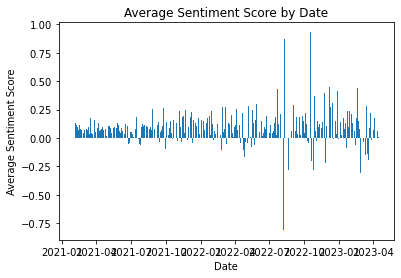

In [295]:
import matplotlib.pyplot as plt

# Group the data by date and calculate the mean sentiment score for each group
grouped = text_data.groupby('date').mean()

# Create a bar plot of the mean sentiment scores for each group
plt.bar(grouped.index, grouped['sentiment_score'])
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Date')
plt.show()
